# Transfer Learning and Fine Tuning 

Follows the transfer learning example, adapted to Wes or not Wes instead of dogs and cats. 


https://www.tensorflow.org/tutorials/images/transfer_learning

Cats and dogs data structure 

```
train/ 
    cats/
        cat.835.jpg
    dogs/
        dog.157.jpg
validation/ 
    cats/
        cat.2273.jpg
    dogs/
        dog.2274.jpg
```

In [1]:
import matplotlib.pyplot as plt
import os
import tensorflow as tf

In [2]:
_URL = "https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip"
path_to_zip = tf.keras.utils.get_file("cats_and_dogs.zip", origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), "cats_and_dogs_filtered")

train_dir = os.path.join(PATH, "train")
validation_dir = os.path.join(PATH, "validation")

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir, shuffle=True, batch_size=BATCH_SIZE, image_size=IMG_SIZE
)

Found 2000 files belonging to 2 classes.


In [3]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(
    validation_dir, shuffle=True, batch_size=BATCH_SIZE, image_size=IMG_SIZE
)

Found 1000 files belonging to 2 classes.


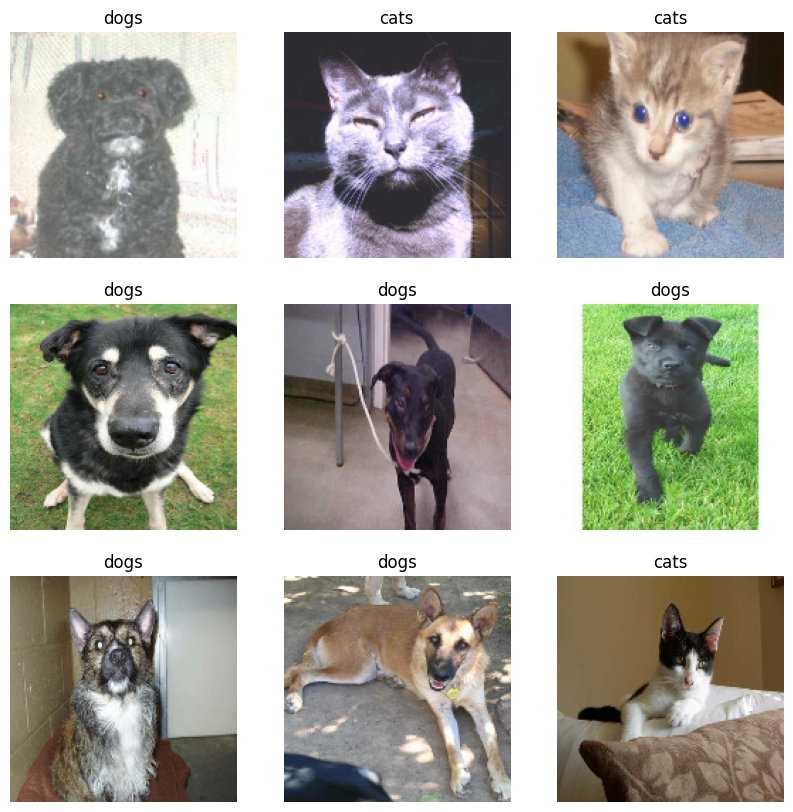

In [4]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [5]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [6]:
print(
    "Number of validation batches: %d"
    % tf.data.experimental.cardinality(validation_dataset)
)
print("Number of test batches: %d" % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 26
Number of test batches: 6


In [7]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [8]:
data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.2),
    ]
)

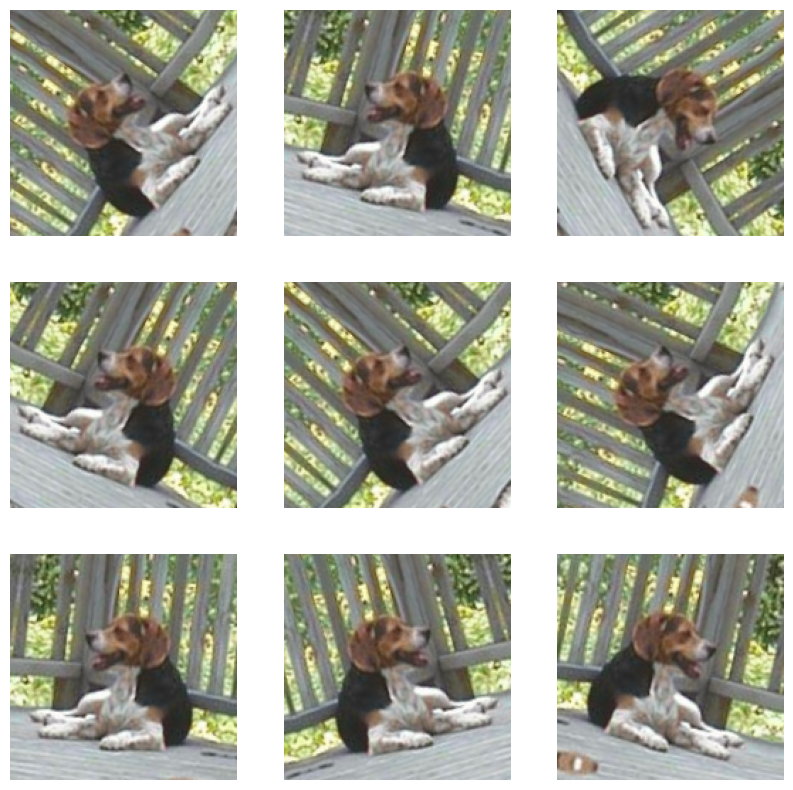

In [9]:
for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis("off")

In [10]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [11]:
# rescale = tf.keras.layers.Rescaling(1.0 / 127.5, offset=-1)

In [12]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(
    input_shape=IMG_SHAPE, include_top=False, weights="imagenet"
)

In [13]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


In [14]:
base_model.trainable = False

In [15]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

In [16]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [17]:
prediction_layer = tf.keras.layers.Dense(1, activation="sigmoid")
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [18]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [19]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

In [20]:
len(model.trainable_variables)

2

In [22]:
base_learning_rate = 0.0001
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5, name="accuracy")],
)

In [23]:
base_learning_rate = 0.0001
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5, name="accuracy")],
)

In [24]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

26/26 [==============================] - 35s 1s/step - loss: 0.7117 - accuracy: 0.5644


In [25]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.71
initial accuracy: 0.56


In [26]:
history = model.fit(
    train_dataset, epochs=initial_epochs, validation_data=validation_dataset
)

Epoch 1/10
63/63 [==============================] - 95s 1s/step - loss: 0.6638 - accuracy: 0.6350 - val_loss: 0.4878 - val_accuracy: 0.7958
Epoch 2/10
63/63 [==============================] - 56s 873ms/step - loss: 0.4922 - accuracy: 0.7700 - val_loss: 0.3578 - val_accuracy: 0.8973
Epoch 3/10
63/63 [==============================] - 56s 891ms/step - loss: 0.4127 - accuracy: 0.8245 - val_loss: 0.2825 - val_accuracy: 0.9270
Epoch 4/10
63/63 [==============================] - 55s 877ms/step - loss: 0.3501 - accuracy: 0.8515 - val_loss: 0.2305 - val_accuracy: 0.9418
Epoch 5/10
63/63 [==============================] - 56s 880ms/step - loss: 0.3068 - accuracy: 0.8795 - val_loss: 0.1930 - val_accuracy: 0.9554
Epoch 6/10
63/63 [==============================] - 61s 968ms/step - loss: 0.2852 - accuracy: 0.8920 - val_loss: 0.1708 - val_accuracy: 0.9653
Epoch 7/10
63/63 [==============================] - 73s 1s/step - loss: 0.2528 - accuracy: 0.9070 - val_loss: 0.1503 - val_accuracy: 0.9691
Epoch

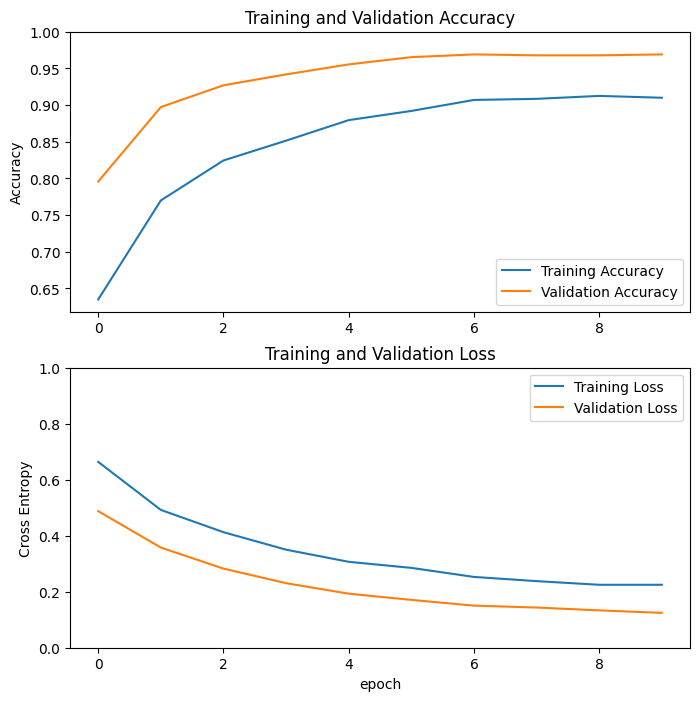

In [27]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label="Training Accuracy")
plt.plot(val_acc, label="Validation Accuracy")
plt.legend(loc="lower right")
plt.ylabel("Accuracy")
plt.ylim([min(plt.ylim()), 1])
plt.title("Training and Validation Accuracy")

plt.subplot(2, 1, 2)
plt.plot(loss, label="Training Loss")
plt.plot(val_loss, label="Validation Loss")
plt.legend(loc="upper right")
plt.ylabel("Cross Entropy")
plt.ylim([0, 1.0])
plt.title("Training and Validation Loss")
plt.xlabel("epoch")
plt.show()

In [28]:
base_model.trainable = True

In [29]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

Number of layers in the base model:  154


In [30]:
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate / 10),
    metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5, name="accuracy")],
)

In [31]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

In [32]:
len(model.trainable_variables)

56

In [33]:
fine_tune_epochs = 10
total_epochs = initial_epochs + fine_tune_epochs

history_fine = model.fit(
    train_dataset,
    epochs=total_epochs,
    initial_epoch=len(history.epoch),
    validation_data=validation_dataset,
)

Epoch 11/20
63/63 [==============================] - 100s 1s/step - loss: 0.1611 - accuracy: 0.9395 - val_loss: 0.0501 - val_accuracy: 0.9839
Epoch 12/20
63/63 [==============================] - 87s 1s/step - loss: 0.1094 - accuracy: 0.9550 - val_loss: 0.0427 - val_accuracy: 0.9913
Epoch 13/20
63/63 [==============================] - 104s 2s/step - loss: 0.0956 - accuracy: 0.9620 - val_loss: 0.0431 - val_accuracy: 0.9864
Epoch 14/20
63/63 [==============================] - 79s 1s/step - loss: 0.0981 - accuracy: 0.9620 - val_loss: 0.0326 - val_accuracy: 0.9901
Epoch 15/20
63/63 [==============================] - 77s 1s/step - loss: 0.0850 - accuracy: 0.9665 - val_loss: 0.0379 - val_accuracy: 0.9839
Epoch 16/20
63/63 [==============================] - 95s 2s/step - loss: 0.0720 - accuracy: 0.9685 - val_loss: 0.0330 - val_accuracy: 0.9864
Epoch 17/20
63/63 [==============================] - 103s 2s/step - loss: 0.0746 - accuracy: 0.9695 - val_loss: 0.0337 - val_accuracy: 0.9889
Epoch 18/2

In [34]:
acc += history_fine.history["accuracy"]
val_acc += history_fine.history["val_accuracy"]

loss += history_fine.history["loss"]
val_loss += history_fine.history["val_loss"]

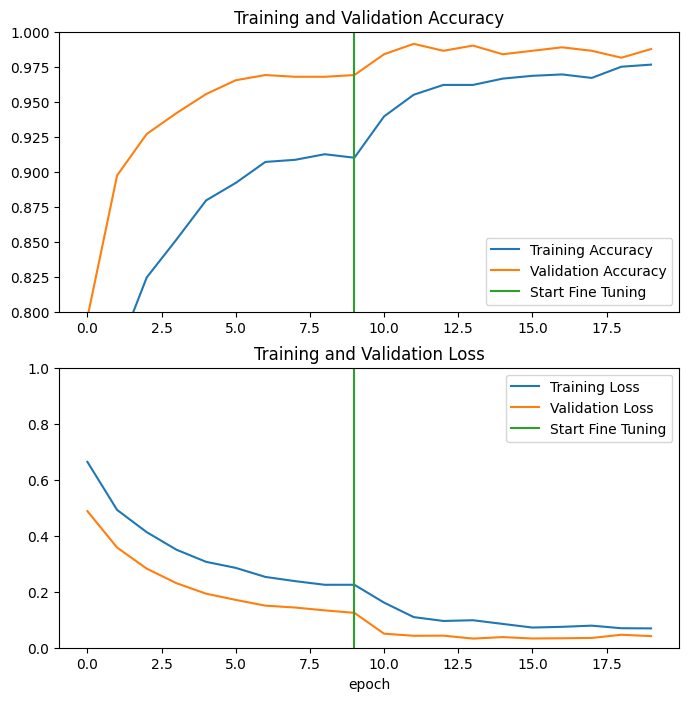

In [35]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label="Training Accuracy")
plt.plot(val_acc, label="Validation Accuracy")
plt.ylim([0.8, 1])
plt.plot(
    [initial_epochs - 1, initial_epochs - 1], plt.ylim(), label="Start Fine Tuning"
)
plt.legend(loc="lower right")
plt.title("Training and Validation Accuracy")

plt.subplot(2, 1, 2)
plt.plot(loss, label="Training Loss")
plt.plot(val_loss, label="Validation Loss")
plt.ylim([0, 1.0])
plt.plot(
    [initial_epochs - 1, initial_epochs - 1], plt.ylim(), label="Start Fine Tuning"
)
plt.legend(loc="upper right")
plt.title("Training and Validation Loss")
plt.xlabel("epoch")
plt.show()

## Evaluation and prediction

Finally you can verify the performance of the model on new data using test set.

In [36]:
loss, accuracy = model.evaluate(test_dataset)
print("Test accuracy :", accuracy)

6/6 [==============================] - 5s 611ms/step - loss: 0.0388 - accuracy: 0.9844
Test accuracy : 0.984375


Predictions:
 [1 0 1 1 0 0 0 1 0 1 1 1 0 1 0 1 1 1 0 1 1 0 0 0 0 1 0 1 1 0 1 1]
Labels:
 [1 0 1 1 0 0 0 1 0 1 1 1 0 1 0 1 1 1 0 1 1 0 0 0 0 1 0 1 1 0 1 1]


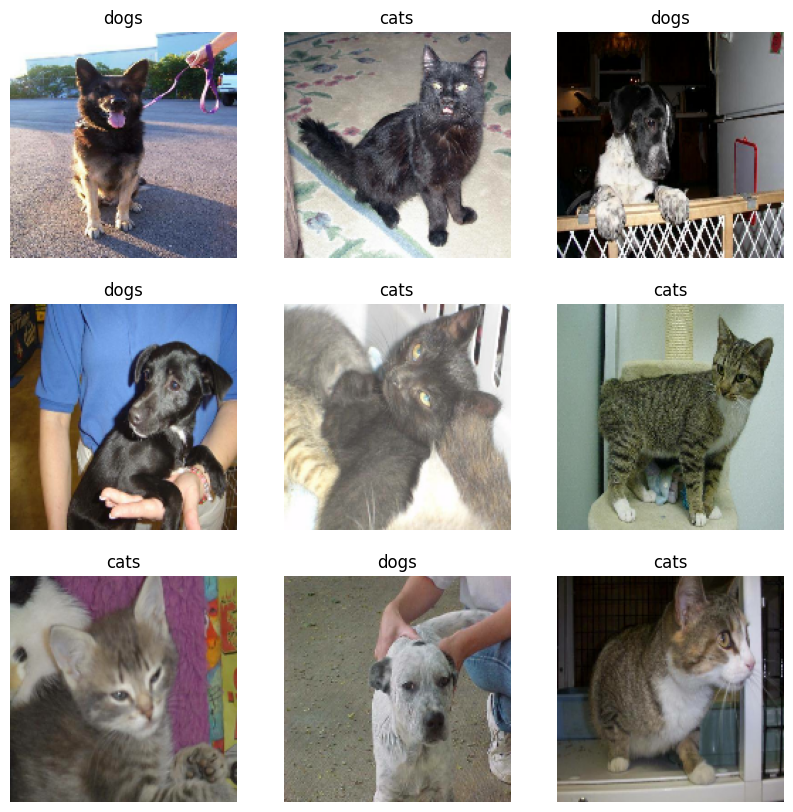

In [37]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

predictions = tf.where(predictions < 0.5, 0, 1)

print("Predictions:\n", predictions.numpy())
print("Labels:\n", label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    plt.title(class_names[predictions[i]])
    plt.axis("off")

In [38]:
model.save("cats_dogs.tf")

INFO:tensorflow:Assets written to: cats_dogs.tf/assets


INFO:tensorflow:Assets written to: cats_dogs.tf/assets
